In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [3]:
train['source']='train'
test['source']='test'
data = pd.concat([train,test], ignore_index = True)
data.to_csv("data.csv",index=False)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [4]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

def impute_weight(cols):
    Weight = cols[0]
    Identifier = cols[1]
    if pd.isnull(Weight):
        return item_avg_weight['Item_Weight'][item_avg_weight.index == Identifier]
    else:
        return Weight
print ('Orignal #missing: %d'%sum(data['Item_Weight'].isnull()))
data['Item_Weight'] = data[['Item_Weight','Item_Identifier']].apply(impute_weight,axis=1).astype(float)
print('Final #missing: %d'%sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [5]:
from scipy.stats import mode

outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=lambda x:x.mode())

def impute_size_mode(cols):
    Size = cols[0]
    Type = cols[1]
    
    if pd.isnull(Size):
        return outlet_size_mode.loc['Outlet_Size'][outlet_size_mode.columns == Type][0]
    else:
        return Size

print('Orignal #missing: %d'%sum(data['Outlet_Size'].isnull()))
data['Outlet_Size'] = data[['Outlet_Size','Outlet_Type']].apply(impute_size_mode,axis=1)
print ('Final #missing: %d'%sum(data['Outlet_Size'].isnull()))

Orignal #missing: 4016
Final #missing: 0


In [6]:
visibility_item_avg = data.pivot_table(values='Item_Visibility',index='Item_Identifier')

def impute_visibility_mean(cols):
    visibility = cols[0]
    item = cols[1]
    if visibility == 0:
        return visibility_item_avg['Item_Visibility'][visibility_item_avg.index == item]
    else:
        return visibility
print ('Original #zeros: %d'%sum(data['Item_Visibility'] == 0))
data['Item_Visibility'] = data[['Item_Visibility','Item_Identifier']].apply(impute_visibility_mean,axis=1).astype(float)
print ('Final #zeros: %d'%sum(data['Item_Visibility'] == 0))

Original #zeros: 879
Final #zeros: 0


In [7]:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [8]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [10]:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
Outlet_1                       uint8
O

In [11]:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
train_df = pd.read_csv('train_modified.csv')
test_df = pd.read_csv('test_modified.csv')

In [13]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])

    cv_score = cross_val_score(alg, dtrain[predictors],(dtrain[target]) , cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error((dtrain[target]).values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

    dtest[target] = alg.predict(dtest[predictors])

    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)


Model Report
RMSE : 1127
CV Score : Mean - 1129 | Std - 43.37 | Min - 1075 | Max - 1210


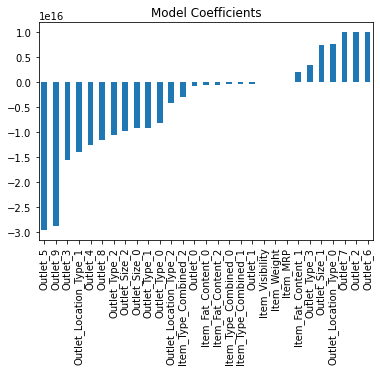

In [14]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

LR = LinearRegression(normalize=True)
predictors = train_df.columns.drop(['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier'])
modelfit(LR, train_df, test_df, predictors, target, IDcol, 'LR.csv')
coef1 = pd.Series(LR.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1128
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


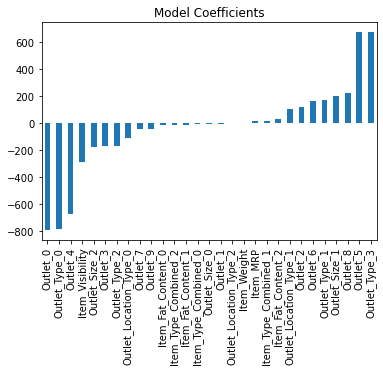

In [15]:
from sklearn.linear_model import Ridge

RR = Ridge(alpha=0.05,normalize=True)
modelfit(RR, train_df, test_df, predictors, target, IDcol, 'RR.csv')
coef2 = pd.Series(RR.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1060
CV Score : Mean - 1091 | Std - 43.48 | Min - 1008 | Max - 1175


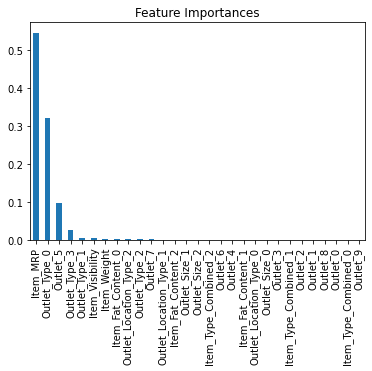

In [16]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(DT, train_df, test_df, predictors, target, IDcol, 'DT.csv')
coef3 = pd.Series(DT.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')